#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션

단계별로 나눠서 모델링을 수행하고자 합니다.  

* 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
* 단계2 : 세부 동작에 대한 분류모델 생성
    * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
    * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 모든 모델링은 [다양한 알고리즘 + 성능 튜닝]을 수행해야 합니다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifier

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용

 <br/>  

* 세부 요구사항
    - data01_train.csv 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - data01_test.csv 를 불러와 'new_data' 이름으로 저장합니다.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
# 전체 데이터 'data01_train.csv' 를 불러와 'data' 이름으로 저장
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/train.csv')
new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/test.csv')

# data에서 변수 subject는 삭제
data.drop(columns = ['Unnamed: 0'], inplace=True)
new_data.drop(columns = ['Unnamed: 0'], inplace=True)

#### 2) 기본 정보 조회

In [61]:
display(data.head())
display(new_data.head())

,A_x,A_y,A_z,B_x,B_y,B_z,label
0,-0.259130,-0.834869,-0.485499,0.196409,NaN,0.384934,8
1,0.370490,0.175042,0.122625,-0.338242,0.358245,0.126491,2
2,-0.257837,-0.881947,-0.391895,0.196027,0.894537,0.411221,8
3,-0.937753,-0.055961,0.362041,-0.929881,0.087673,0.134609,11
4,-0.988320,-0.190390,0.157909,-0.954669,-0.024810,-0.388420,6


,A_x,A_y,A_z,B_x,B_y,B_z
0,-1.000957,-0.170691,0.124889,-0.979561,0.003150,-0.264673
1,-0.874830,0.132696,-0.501727,-1.274911,0.045122,0.121270
2,-1.219112,0.074678,0.435331,-0.860820,0.222740,0.008689
3,-0.907752,-0.171816,0.211507,-0.972017,0.337799,1.013534
4,-1.031261,0.000340,-0.091693,-0.217434,-0.323466,0.931614


In [72]:
print(data.shape)
print(new_data.shape)

(53219, 7)
(13234, 6)


In [73]:
print(data.isna().sum())
print(new_data.isna().sum())

A_x      0
A_y      0
A_z      0
B_x      0
B_y      0
B_z      0
label    0
dtype: int64
A_x    0
A_y    0
A_z    0
B_x    0
B_y    0
B_z    0
dtype: int64


In [74]:
data.dropna(inplace=True)
new_data.dropna(inplace=True)

In [75]:
print(data.describe())
print(new_data.describe())

                A_x           A_y           A_z           B_x           B_y  \
count  53219.000000  53219.000000  53219.000000  53219.000000  53219.000000   
mean      -0.877294     -0.108733     -0.013489     -0.779756      0.115047   
std        0.463339      0.347211      0.361346      0.813368      0.592512   
min       -5.112929     -1.949310     -1.284750     -7.483251     -5.381570   
25%       -1.016930     -0.179784     -0.281388     -1.049334     -0.192097   
50%       -0.958883     -0.047223     -0.063627     -0.918018      0.022717   
75%       -0.766159      0.060663      0.221118     -0.158293      0.317289   
max        1.849398      2.413866      2.457464      5.372528      7.182237   

                B_z         label  
count  53219.000000  53219.000000  
mean       0.165634      5.929762  
std        0.786266      3.334749  
min       -7.208220      1.000000  
25%       -0.245943      3.000000  
50%        0.111824      6.000000  
75%        0.526061      9.000000  


## 2.그냥 돌려보기

<< 기초통계량 >>


,count,mean,std,min,25%,50%,75%,max
label,53219.0,5.929762,3.334749,1.0,3.0,6.0,9.0,11.0


<< 그래프 >>
<< 범주별 빈도수 >>
2     6453
1     6188
8     6056
7     5670
10    5068
9     4891
11    4838
3     4428
4     3853
5     2913
6     2861
Name: label, dtype: int64
<< 범주별 비율 >>
2     0.121254
1     0.116274
8     0.113794
7     0.106541
10    0.095229
9     0.091903
11    0.090907
3     0.083203
4     0.072399
5     0.054736
6     0.053759
Name: label, dtype: float64


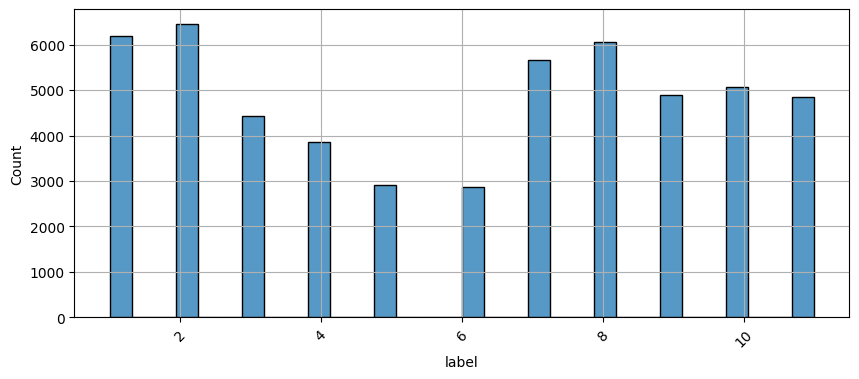

In [76]:
def eda_1_num(data, target):

    # 기초통계량
    print('<< 기초통계량 >>')
    display(data[[target]].describe().T)
    print('=' * 100)

    # 시각화
    print('<< 그래프 >>')
    plt.figure(figsize=(10, 4))
    sns.histplot(data[target])
    plt.grid()
    plt.xticks(rotation=45)

    category_counts = data[target].value_counts()
    category_proportions = data[target].value_counts(normalize=True)

    print('<< 범주별 빈도수 >>')
    print(category_counts)
    print('=' * 100)

    print('<< 범주별 비율 >>')
    print(category_proportions)
    print('=' * 100)

target = 'label'
eda_1_num(data, target)

In [77]:
from imblearn.over_sampling import SMOTE

# SMOTE 객체 생성
smote = SMOTE(random_state=42)
y_train = data['label']
X_train = data.drop(columns = 'label')
# X_train, y_train은 훈련 데이터의 특징과 레이블을 나타냅니다.
# 이 두 변수를 사용하여 SMOTE를 적용합니다.
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)  # X_train.columns는 특징 열의 이름들을 나타냅니다
y_resampled_df = pd.Series(y_resampled, name='label')  # 'target'은 새로운 레이블 열의 이름입니다

# X_resampled_df와 y_resampled_df를 합쳐서 resampled_df를 생성
resampled_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)
resampled_df

,A_x,A_y,A_z,B_x,B_y,B_z,label
0,0.370490,0.175042,0.122625,-0.338242,0.358245,0.126491,2
1,-0.257837,-0.881947,-0.391895,0.196027,0.894537,0.411221,8
2,-0.937753,-0.055961,0.362041,-0.929881,0.087673,0.134609,11
3,-0.988320,-0.190390,0.157909,-0.954669,-0.024810,-0.388420,6
4,-0.654583,0.068285,-0.029109,-0.176341,-0.256252,-0.510816,2
...,...,...,...,...,...,...,...
70978,-0.937101,-0.115067,0.341359,-0.805431,-0.263936,0.182348,11
70979,-0.997864,-0.074420,0.273372,-1.073208,0.212859,0.068700,11
70980,-0.926530,-0.058349,0.468366,-1.258490,-0.058865,0.092309,11
70981,-0.596472,-0.015233,0.280113,-1.097080,0.130267,0.125839,11


<< 기초통계량 >>


,count,mean,std,min,25%,50%,75%,max
label,70983.0,6.0,3.1623,1.0,3.0,6.0,9.0,11.0


<< 그래프 >>
<< 범주별 빈도수 >>
2     6453
8     6453
11    6453
6     6453
4     6453
5     6453
10    6453
1     6453
3     6453
7     6453
9     6453
Name: label, dtype: int64
<< 범주별 비율 >>
2     0.090909
8     0.090909
11    0.090909
6     0.090909
4     0.090909
5     0.090909
10    0.090909
1     0.090909
3     0.090909
7     0.090909
9     0.090909
Name: label, dtype: float64


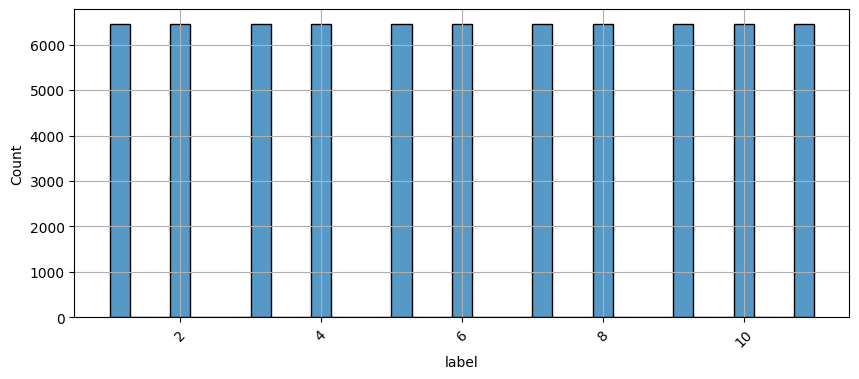

In [78]:
def eda_1_num(data, target):

    # 기초통계량
    print('<< 기초통계량 >>')
    display(data[[target]].describe().T)
    print('=' * 100)

    # 시각화
    print('<< 그래프 >>')
    plt.figure(figsize=(10, 4))
    sns.histplot(data[target])
    plt.grid()
    plt.xticks(rotation=45)

    category_counts = data[target].value_counts()
    category_proportions = data[target].value_counts(normalize=True)

    print('<< 범주별 빈도수 >>')
    print(category_counts)
    print('=' * 100)

    print('<< 범주별 비율 >>')
    print(category_proportions)
    print('=' * 100)

target = 'label'
eda_1_num(resampled_df, target)

In [79]:
resampled_df

,A_x,A_y,A_z,B_x,B_y,B_z,label
0,0.370490,0.175042,0.122625,-0.338242,0.358245,0.126491,2
1,-0.257837,-0.881947,-0.391895,0.196027,0.894537,0.411221,8
2,-0.937753,-0.055961,0.362041,-0.929881,0.087673,0.134609,11
3,-0.988320,-0.190390,0.157909,-0.954669,-0.024810,-0.388420,6
4,-0.654583,0.068285,-0.029109,-0.176341,-0.256252,-0.510816,2
...,...,...,...,...,...,...,...
70978,-0.937101,-0.115067,0.341359,-0.805431,-0.263936,0.182348,11
70979,-0.997864,-0.074420,0.273372,-1.073208,0.212859,0.068700,11
70980,-0.926530,-0.058349,0.468366,-1.258490,-0.058865,0.092309,11
70981,-0.596472,-0.015233,0.280113,-1.097080,0.130267,0.125839,11


In [80]:
new_data

,A_x,A_y,A_z,B_x,B_y,B_z
0,-1.000957,-0.170691,0.124889,-0.979561,0.003150,-0.264673
1,-0.874830,0.132696,-0.501727,-1.274911,0.045122,0.121270
2,-1.219112,0.074678,0.435331,-0.860820,0.222740,0.008689
3,-0.907752,-0.171816,0.211507,-0.972017,0.337799,1.013534
4,-1.031261,0.000340,-0.091693,-0.217434,-0.323466,0.931614
...,...,...,...,...,...,...
13229,-1.379061,0.070504,-0.528339,-1.154145,0.097546,-0.537505
13230,-1.039895,-0.122421,0.065954,-1.152930,0.294010,1.080373
13231,-1.176883,-0.218801,-0.581625,-0.809665,0.126385,0.314077
13232,-0.912287,-0.148846,-0.141693,-1.382983,0.102818,0.933066


In [81]:
# x, y로 나누기
y = resampled_df['label']
x = resampled_df.drop(columns = 'label')

# train과 validation 분할 수행
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x, y, stratify = y, random_state=42, test_size=0.2)

In [82]:
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier()
model_RF.fit(X_train, y_train)

# 성능 평가
from sklearn.metrics import accuracy_score
y_pred = model_RF.predict(X_val)
print(accuracy_score(y_val, y_pred))

0.9197717827710079
0.9191378460238079
0.9200535324364302


KeyboardInterrupt: ignored

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 모델 초기화
model = RandomForestClassifier()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 그리드 서치 객체 생성
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# 그리드 서치 수행
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 및 성능 출력
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.9153312379296563


In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# 모델 초기화
model = RandomForestClassifier()

# 탐색할 하이퍼파라미터 분포 정의
param_dist = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# 랜덤 서치 객체 생성
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy')

# 랜덤 서치 수행
random_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 및 성능 출력
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40}
Best Score: 0.91589473602117


In [ ]:
# 스케일링 (선택사항)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier()
model_RF.fit(x, y)

# 성능 평가
from sklearn.metrics import accuracy_score
y_pred = model_RF.predict(new_data)
# print(accuracy_score(y_val, y_pred))

# 예측 결과를 DataFrame으로 만들기
result_df = pd.DataFrame({'label': y_pred})

# CSV 파일로 저장
result_df.to_csv('prediction_results1.csv', index_label='ID')

pd.read_csv('prediction_results1.csv')


,ID,label
0,0,6
1,1,4
2,2,11
3,3,9
4,4,7
...,...,...
13229,13229,4
13230,13230,9
13231,13231,4
13232,13232,1


In [ ]:
for n in range(3):
    models = [
            ('ada', AdaBoostClassifier()),
            ('bc', BaggingClassifier()),
            ('etc',ExtraTreesClassifier()),
            ('gbc', GradientBoostingClassifier()),
            ('rfc', RandomForestClassifier()),
            ('knn', KNeighborsClassifier()),
            ('svc', SVC(probability=True)),
            ('xgb', XGBClassifier()),
            # ('lgbm', LGBMClassifier()),
            ('dtc', DecisionTreeClassifier()),
            ('lr', LogisticRegressionCV(max_iter=1000)),
            # ('ridge', RidgeClassifier()),
        ]

    from sklearn.ensemble import VotingClassifier

    # 투표 모델 생성
    voting_soft = VotingClassifier(models, voting='soft')
    voting_hard = VotingClassifier(models, voting='hard')

    # 투표 모델 학습
    voting_soft.fit(X_train, y_train)
    voting_hard.fit(X_train, y_train)

    # 최종 예측
    final_predictions = voting_soft.predict(X_val)
    final_predictions2 = voting_hard.predict(X_val)

    from sklearn.metrics import accuracy_score, f1_score

    final_accuracy = accuracy_score(y_val, final_predictions)
    final_macro_f1 = f1_score(y_val, final_predictions, average='macro')

    final_accuracy2 = accuracy_score(y_val, final_predictions2)
    final_macro_f12 = f1_score(y_val, final_predictions2, average='macro')


    print(f"n={n}: Final voting_soft Accuracy={final_accuracy:.4f}, Final voting_soft Macro F1 Score={final_macro_f1:.4f}")
    print(f"n={n}: Final voting_soft Accuracy={final_accuracy2:.4f}, Final voting_soft Macro F1 Score={final_macro_f12:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

n=0: Final voting_soft Accuracy=0.9155, Final voting_soft Macro F1 Score=0.9155
n=0: Final voting_soft Accuracy=0.9133, Final voting_soft Macro F1 Score=0.9133


KeyboardInterrupt: ignored

In [ ]:
models = [
        # ('ada', AdaBoostClassifier()),
        ('rfc', RandomForestClassifier()),
        ('knn', KNeighborsClassifier()),
        ('svc', SVC(probability=True)),
        ('xgb', XGBClassifier()),
        ('dtc', DecisionTreeClassifier()),
        ('lr', LogisticRegressionCV(max_iter=1000)),
    ]

from sklearn.ensemble import VotingClassifier

# 투표 모델 생성
voting_soft = VotingClassifier(models, voting='soft')
# voting_hard = VotingClassifier(models, voting='hard')

# 투표 모델 학습
voting_soft.fit(X_train, y_train)
# voting_hard.fit(X_train, y_train)

# 최종 예측
final_predictions = voting_soft.predict(X_val)
# final_predictions2 = voting_hard.predict(X_val)

from sklearn.metrics import accuracy_score, f1_score

final_accuracy = accuracy_score(y_val, final_predictions)
final_macro_f1 = f1_score(y_val, final_predictions, average='macro')

# final_accuracy2 = accuracy_score(y_val, final_predictions2)
# final_macro_f12 = f1_score(y_val, final_predictions2, average='macro')

# print(f"n={n}: Final voting_soft Accuracy={final_accuracy:.4f}, Final voting_soft Macro F1 Score={final_macro_f1:.4f}")
print(f"n={n}: Final voting_hard Accuracy={final_accuracy2:.4f}, Final voting_hard Macro F1 Score={final_macro_f12:.4f}")


## 2.데이터 전처리

## (1) 상위 N개의 feature 선정

* 세부 요구사항
    - (옵션) 알고리즘 중 1~2개에 대해서, 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것이다.

In [22]:
plot_feature_importances = model_RF.feature_importances_
indices = np.argsort(plot_feature_importances)[::-1]

Feature_names = X_train.columns

# 상위 10개
top_importances = []
print("상위 10개 변수:")
for idx in indices[:]:
    top_importances.append(Feature_names[idx])
top_importances

상위 10개 변수:


['A_z', 'B_z', 'B_x', 'A_x', 'A_y', 'B_y']

In [47]:
indices

array([2, 5, 3, 0, 1, 4])

<ipython-input-43-aabf296e5c54>:12: UserWarning: 
The palette list has fewer values (6) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(data=X_train, x=top_importances[i], hue=y_train, common_norm=False, ax=ax, fill=True, palette=colors)
<ipython-input-43-aabf296e5c54>:12: UserWarning: 
The palette list has fewer values (6) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(data=X_train, x=top_importances[i], hue=y_train, common_norm=False, ax=ax, fill=True, palette=colors)
<ipython-input-43-aabf296e5c54>:12: UserWarning: 
The palette list has fewer values (6) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.kdeplot(data=X_train, x=top_importances[i], hue=y_train, common_norm=False, ax=ax, fill=True, palette=colors)
<ipython-input-43-aabf296e5c54>:12: UserWarning: 
The palette list has fewer values (6) than needed (11) and will cycle, which may produce an uninterpretable pl

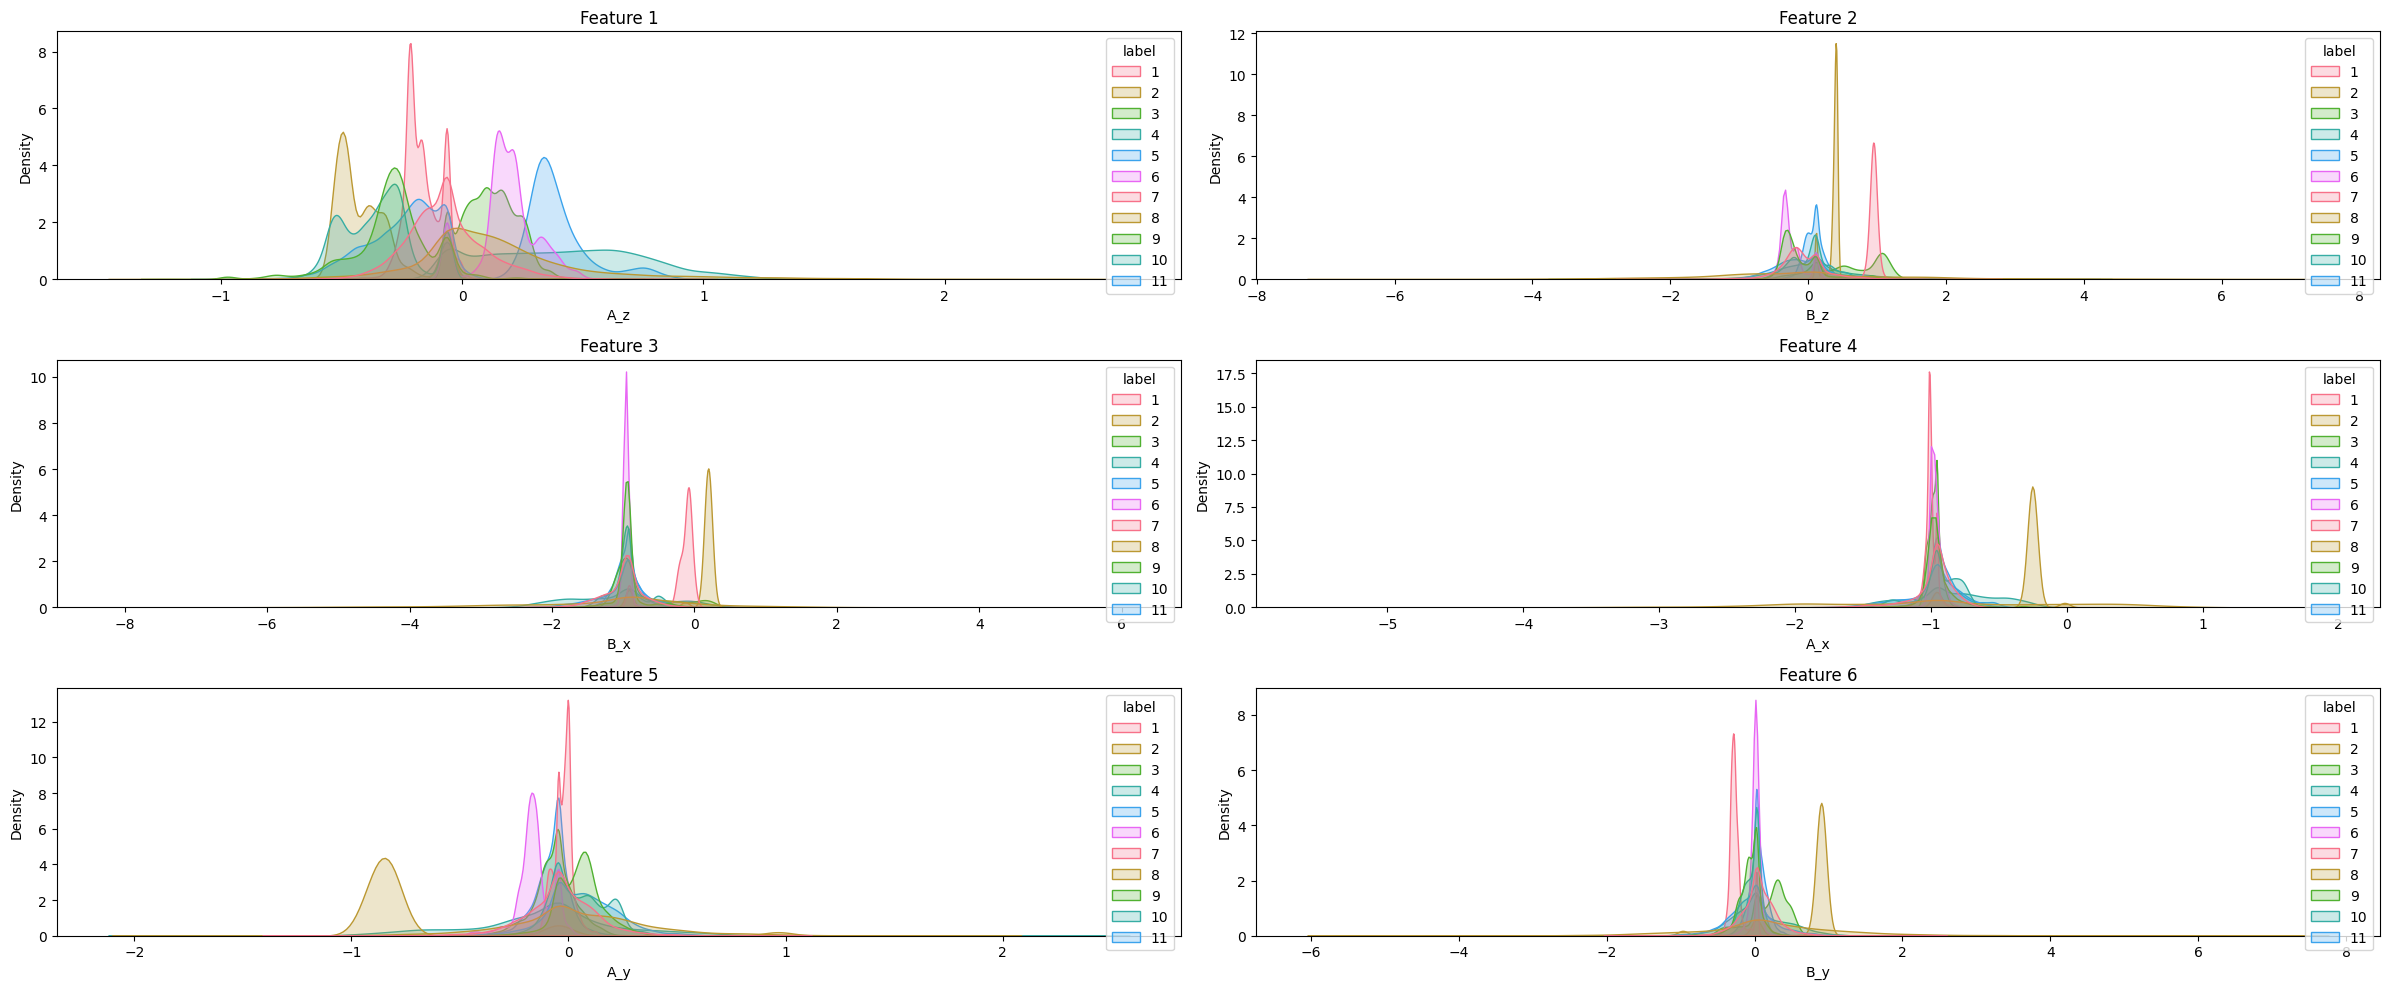

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# 색상 팔레트 설정
colors = sns.color_palette("husl")

# 그래프를 2x3 타일 형태로 배치
fig, axes = plt.subplots(3, 2, figsize=(24, 10))

# 각각의 그래프를 그리기
for i, ax in enumerate(axes.flat):
    sns.kdeplot(data=X_train, x=top_importances[i], hue=y_train, common_norm=False, ax=ax, fill=True, palette=colors)
    ax.set_title(f"Feature {i+1}")

# 그래프 간 간격 조절
plt.tight_layout()

# 그래프 표시
plt.show()


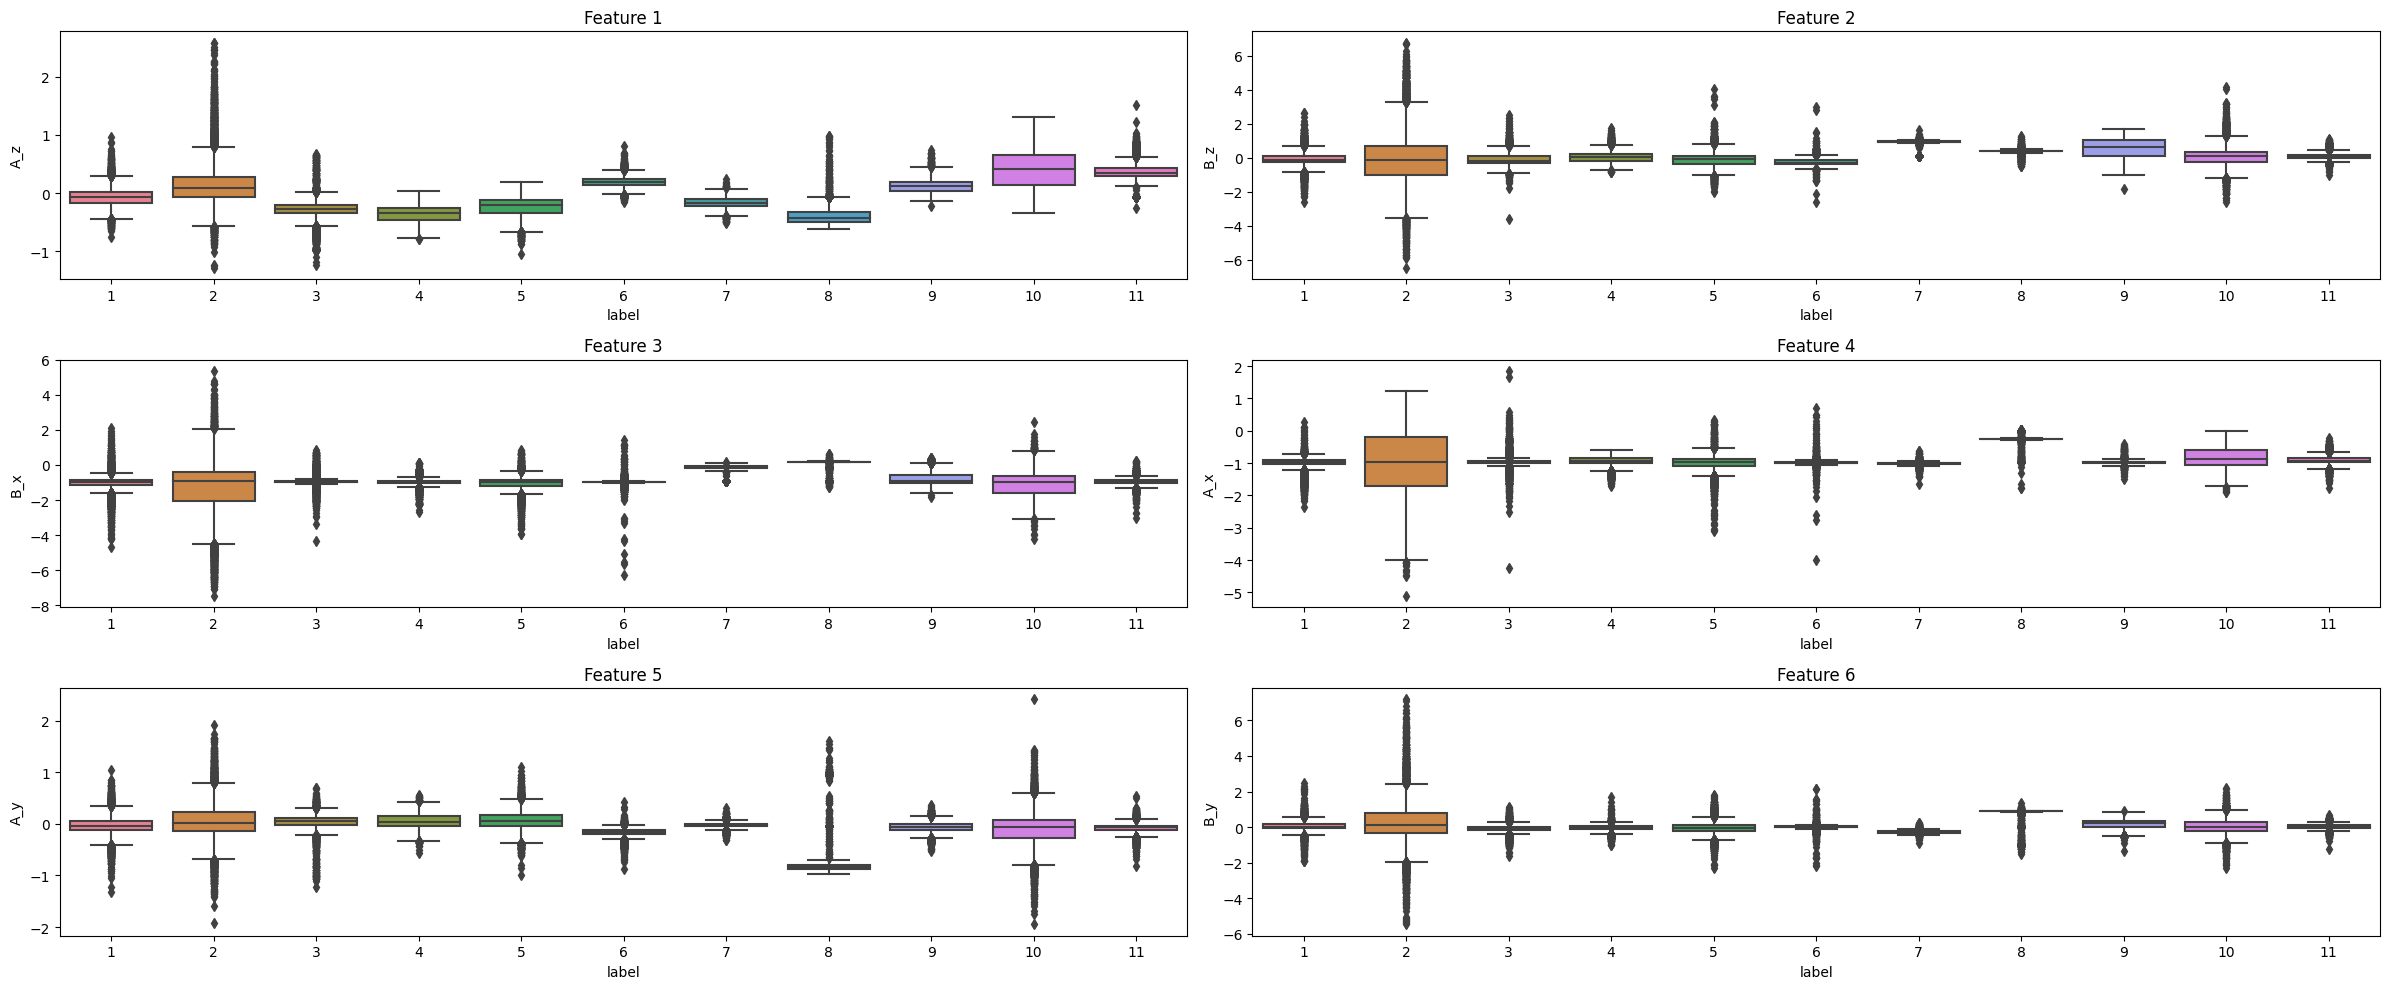

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프를 2x3 타일 형태로 배치
fig, axes = plt.subplots(3, 2, figsize=(24, 10))

# 각각의 그래프를 그리기
for i, ax in enumerate(axes.flat):
    sns.boxplot(x=y_train, y=X_train[top_importances[i]], ax=ax, palette="husl")
    ax.set_title(f"Feature {i+1}")

# 그래프 간 간격 조절
plt.tight_layout()

# 그래프 표시
plt.show()


In [54]:
# x, y로 나누기
y = resampled_df['label']
x = resampled_df.drop(columns = ['label', 'A_z'])

# train과 validation 분할 수행
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x, y, stratify = y, random_state=42, test_size=0.2)

# 랜덤포레스트 이용하여 모델링
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(random_state=42)
model_RF.fit(X_train, y_train)

# 성능 평가
from sklearn.metrics import accuracy_score
y_pred = model_RF.predict(X_val)
accuracy_score(y_val, y_pred)

0.8175842235004108

In [56]:
# x, y로 나누기
y = resampled_df['label']
x = resampled_df.drop(columns = ['label', 'A_x'])

# train과 validation 분할 수행
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x, y, stratify = y, random_state=42, test_size=0.2)

# 랜덤포레스트 이용하여 모델링
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(random_state=42)
model_RF.fit(X_train, y_train)

# 성능 평가
from sklearn.metrics import accuracy_score
y_pred = model_RF.predict(X_val)
accuracy_score(y_val, y_pred)

0.8599013968775678

* 세부 요구사항
    - Label 추가 : data 에 Activity_dynamic 를 추가합니다. Activity_dynamic은 과제1에서 is_dynamic과 동일한 값입니다.
    - x와 y1, y2로 분할하시오.
        * y1 : Activity
        * y2 : Activity_dynamic
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [ ]:
non_dynamic = ['SITTING', 'STANDING', 'LAYING']
data_topN['Activity_dynamic'] = data_topN['Activity'].map(lambda x: 0 if x in non_dynamic else 1)
data_topN

<ipython-input-14-0714c322615e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_topN['Activity_dynamic'] = data_topN['Activity'].map(lambda x: 0 if x in non_dynamic else 1)


,tGravityAcc-max()-Y,tGravityAcc-mean()-X,tGravityAcc-min()-Y,"angle(Y,gravityMean)",tGravityAcc-max()-X,tGravityAcc-min()-X,tGravityAcc-mean()-Y,tGravityAcc-energy()-X,"angle(X,gravityMean)",tGravityAcc-energy()-Y,Activity,Activity_dynamic
0,0.084381,0.939996,0.148733,0.900647,0.902470,0.945608,0.114889,0.847111,0.201725,0.112032,STANDING,0
1,0.935031,0.418889,0.960101,0.156150,0.397433,0.448509,0.950923,0.053734,0.680309,0.857254,LAYING,0
2,0.203944,0.986800,0.269332,0.813468,0.945616,0.992753,0.235228,0.964773,0.084172,0.023478,STANDING,0
3,0.126143,0.966872,0.186498,0.870783,0.928829,0.971781,0.154713,0.913741,0.153833,0.075452,WALKING,1
4,0.176305,0.953344,0.194289,0.855762,0.929016,0.950630,0.178920,0.879993,0.149176,0.057392,WALKING_DOWNSTAIRS,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.294301,0.990544,0.344852,0.753647,0.949340,0.996172,0.319908,0.974518,0.044320,0.000692,SITTING,0
5877,0.115250,0.958404,0.176487,0.881634,0.921564,0.960225,0.141807,0.892480,0.156635,0.086519,WALKING_UPSTAIRS,1
5878,0.775416,0.223075,0.809293,0.380712,0.207527,0.262386,0.794759,0.000728,0.819464,0.476680,LAYING,0
5879,0.122627,0.963885,0.175178,0.874641,0.926022,0.965958,0.151406,0.906216,0.142611,0.078266,WALKING_UPSTAIRS,1


In [ ]:
# x, y로 나누기
y1 = data_topN['Activity']
y2 = data_topN['Activity_dynamic']
x = data_topN.drop(columns = ['Activity_dynamic', 'Activity'])

In [ ]:
# train과 validation 분할 수행
from sklearn.model_selection import train_test_split
X_train_dynamic, X_val_dynamic, y_train_dynamic, y_val_dynamic = train_test_split(x, y2, stratify = y2, random_state=42, test_size=0.25)

## **3.단계별 모델링**

![](https://github.com/DA4BAM/image/blob/main/step%20by%20step.png?raw=true)

### (1) 단계1 : 정적/동적 행동 분류 모델

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 알고리즘1 :

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

clf_random_forest = RandomForestClassifier(random_state=42)
clf_random_forest.fit(X_train_dynamic, y_train_dynamic)

predicted_random_forest = clf_random_forest.predict(X_val_dynamic)
macro_f1_score_random_forest = f1_score(y_val_dynamic, predicted_random_forest, average='macro')
print("RandomForestClassifier Accuracy Score:", np.mean(predicted_random_forest == y_val_dynamic))
print("RandomForestClassifier Macro F1 Score:", macro_f1_score_random_forest)

RandomForestClassifier Accuracy Score: 0.9564921821889871
RandomForestClassifier Macro F1 Score: 0.9561654449013648


#### 2) 알고리즘2 :

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score

clf_SGD = SGDClassifier(random_state=42)
clf_SGD.fit(X_train_dynamic, y_train_dynamic)

predicted = clf_SGD.predict(X_val_dynamic)
macro_f1_score = f1_score(y_val_dynamic, predicted, average='macro')
print('Accuracy Score :', np.mean(predicted == y_val_dynamic))
print("Macro F1 Score:", macro_f1_score)

Accuracy Score : 0.7940176750509857
Macro F1 Score: 0.7938942311027053


In [ ]:
from sklearn.linear_model import LogisticRegression

clf_logistic = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
clf_logistic.fit(X_train_dynamic, y_train_dynamic)

predicted_logistic = clf_logistic.predict(X_val_dynamic)
macro_f1_score_logistic = f1_score(y_val_dynamic, predicted_logistic, average='macro')
print("Accuracy Score:", np.mean(predicted_logistic == y_val_dynamic))
print("Macro F1 Score:", macro_f1_score_logistic)

Accuracy Score: 0.7743031951053705
Macro F1 Score: 0.7738340020524677


In [ ]:
from sklearn.svm import SVC

clf_svm = SVC(kernel='linear', random_state=42)
clf_svm.fit(X_train_dynamic, y_train_dynamic)

predicted_svm = clf_svm.predict(X_val_dynamic)
macro_f1_score_svm = f1_score(y_val_dynamic, predicted_svm, average='macro')
print("SVM Accuracy Score:", np.mean(predicted_svm == y_val_dynamic))
print("SVM Macro F1 Score:", macro_f1_score_svm)


SVM Accuracy Score: 0.7933378653976887
SVM Macro F1 Score: 0.7923589829312234


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train_dynamic, y_train_dynamic)

predicted_knn = clf_knn.predict(X_val_dynamic)
macro_f1_score_knn = f1_score(y_val_dynamic, predicted_knn, average='macro')
accuracy_knn = np.mean(predicted_knn == y_val_dynamic)
print("KNeighborsClassifier Accuracy Score:", accuracy_knn)
print("KNeighborsClassifier Macro F1 Score:", macro_f1_score_knn)


KNeighborsClassifier Accuracy Score: 0.9354180829367778
KNeighborsClassifier Macro F1 Score: 0.934793208918835


### (2) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
data_Activity_dynamic = data_topN[data_topN['Activity_dynamic'] == 0]
data_Activity_dynamic

,tGravityAcc-max()-Y,tGravityAcc-mean()-X,tGravityAcc-min()-Y,"angle(Y,gravityMean)",tGravityAcc-max()-X,tGravityAcc-min()-X,tGravityAcc-mean()-Y,tGravityAcc-energy()-X,"angle(X,gravityMean)",tGravityAcc-energy()-Y,Activity,Activity_dynamic
0,0.084381,0.939996,0.148733,0.900647,0.902470,0.945608,0.114889,0.847111,0.201725,0.112032,STANDING,0
1,0.935031,0.418889,0.960101,0.156150,0.397433,0.448509,0.950923,0.053734,0.680309,0.857254,LAYING,0
2,0.203944,0.986800,0.269332,0.813468,0.945616,0.992753,0.235228,0.964773,0.084172,0.023478,STANDING,0
7,0.367394,0.978168,0.420523,0.702054,0.937574,0.983431,0.392556,0.942498,0.092447,0.007057,STANDING,0
8,0.185446,0.979644,0.208235,0.840799,0.940421,0.978761,0.197008,0.946301,0.110212,0.045169,STANDING,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5874,0.683313,0.105641,0.311401,0.653503,0.155450,0.138916,0.452940,0.033803,0.906757,0.075213,LAYING,0
5875,0.185506,0.985418,0.249911,0.827125,0.944364,0.991141,0.215998,0.961191,0.091910,0.033208,STANDING,0
5876,0.294301,0.990544,0.344852,0.753647,0.949340,0.996172,0.319908,0.974518,0.044320,0.000692,SITTING,0
5878,0.775416,0.223075,0.809293,0.380712,0.207527,0.262386,0.794759,0.000728,0.819464,0.476680,LAYING,0


In [ ]:
# x, y로 나누기
y2 = data_Activity_dynamic['Activity']
x = data_Activity_dynamic.drop(columns = ['Activity_dynamic', 'Activity'])
# train과 validation 분할 수행
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x, y2, stratify = y2, random_state=42, test_size=0.25)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

clf_random_forest = RandomForestClassifier(random_state=42)
clf_random_forest.fit(X_train, y_train)

predicted_random_forest = clf_random_forest.predict(X_val)
macro_f1_score_random_forest = f1_score(y_val, predicted_random_forest, average='macro')
print("RandomForestClassifier Accuracy Score:", np.mean(predicted_random_forest == y_val))
print("RandomForestClassifier Macro F1 Score:", macro_f1_score_random_forest)

RandomForestClassifier Accuracy Score: 0.9629171817058096
RandomForestClassifier Macro F1 Score: 0.9622297287666939


In [ ]:
from sklearn.linear_model import LogisticRegression

clf_logistic = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
clf_logistic.fit(X_train, y_train)

predicted_logistic = clf_logistic.predict(X_val)
macro_f1_score_logistic = f1_score(y_val, predicted_logistic, average='macro')
print("Accuracy Score:", np.mean(predicted_logistic == y_val))
print("Macro F1 Score:", macro_f1_score_logistic)

Accuracy Score: 0.9258343634116193
Macro F1 Score: 0.9242857219601407


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score

clf_SGD = SGDClassifier(random_state=42)
clf_SGD.fit(X_train, y_train)

predicted = clf_SGD.predict(X_val)
macro_f1_score = f1_score(y_val, predicted, average='macro')
print('Accuracy Score :', np.mean(predicted == y_val))
print("Macro F1 Score:", macro_f1_score)

Accuracy Score : 0.9394313967861557
Macro F1 Score: 0.9383645604529267


In [ ]:
from sklearn.svm import SVC

clf_svm = SVC(kernel='linear', random_state=42)
clf_svm.fit(X_train, y_train)

predicted_svm = clf_svm.predict(X_val)
macro_f1_score_svm = f1_score(y_val, predicted_svm, average='macro')
print("SVM Accuracy Score:", np.mean(predicted_svm == y_val))
print("SVM Macro F1 Score:", macro_f1_score_svm)


SVM Accuracy Score: 0.927070457354759
SVM Macro F1 Score: 0.9256206701751256


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)

predicted_knn = clf_knn.predict(X_val)
macro_f1_score_knn = f1_score(y_val, predicted_knn, average='macro')
accuracy_knn = np.mean(predicted_knn == y_val)
print("KNeighborsClassifier Accuracy Score:", accuracy_knn)
print("KNeighborsClassifier Macro F1 Score:", macro_f1_score_knn)

KNeighborsClassifier Accuracy Score: 0.9542645241038319
KNeighborsClassifier Macro F1 Score: 0.9534111872544792


### (3) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
data_Activity_dynamic = data_topN[data_topN['Activity_dynamic'] == 1]
data_Activity_dynamic

,tGravityAcc-max()-Y,tGravityAcc-mean()-X,tGravityAcc-min()-Y,"angle(Y,gravityMean)",tGravityAcc-max()-X,tGravityAcc-min()-X,tGravityAcc-mean()-Y,tGravityAcc-energy()-X,"angle(X,gravityMean)",tGravityAcc-energy()-Y,Activity,Activity_dynamic
3,0.126143,0.966872,0.186498,0.870783,0.928829,0.971781,0.154713,0.913741,0.153833,0.075452,WALKING,1
4,0.176305,0.953344,0.194289,0.855762,0.929016,0.950630,0.178920,0.879993,0.149176,0.057392,WALKING_DOWNSTAIRS,1
5,0.170721,0.914689,0.215525,0.848275,0.879781,0.918971,0.188806,0.786676,0.226198,0.049955,WALKING_UPSTAIRS,1
6,0.239653,0.991293,0.281862,0.793784,0.956631,0.989347,0.263052,0.976514,0.057348,0.012446,WALKING,1
12,0.148264,0.971955,0.207184,0.856965,0.936092,0.976212,0.175226,0.926632,0.124975,0.059418,WALKING,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5868,0.262115,0.955143,0.308172,0.780684,0.924716,0.956091,0.282013,0.884388,0.155935,0.006903,WALKING,1
5869,0.165126,0.964411,0.221149,0.847824,0.929142,0.965642,0.190142,0.907550,0.113527,0.048956,WALKING_UPSTAIRS,1
5873,0.080324,0.937553,0.146224,0.903825,0.900159,0.940771,0.111462,0.841179,0.201480,0.115503,WALKING,1
5877,0.115250,0.958404,0.176487,0.881634,0.921564,0.960225,0.141807,0.892480,0.156635,0.086519,WALKING_UPSTAIRS,1


In [ ]:
# x, y로 나누기
y2 = data_Activity_dynamic['Activity']
x = data_Activity_dynamic.drop(columns = ['Activity_dynamic', 'Activity'])

# train과 validation 분할 수행
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x, y2, stratify = y2, random_state=42, test_size=0.25)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

clf_random_forest = RandomForestClassifier(random_state=42)
clf_random_forest.fit(X_train, y_train)

predicted_random_forest = clf_random_forest.predict(X_val)
macro_f1_score_random_forest = f1_score(y_val, predicted_random_forest, average='macro')
print("RandomForestClassifier Accuracy Score:", np.mean(predicted_random_forest == y_val))
print("RandomForestClassifier Macro F1 Score:", macro_f1_score_random_forest)

RandomForestClassifier Accuracy Score: 0.8459214501510574
RandomForestClassifier Macro F1 Score: 0.8390055524587074


In [ ]:
from sklearn.linear_model import LogisticRegression

clf_logistic = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
clf_logistic.fit(X_train, y_train)

predicted_logistic = clf_logistic.predict(X_val)
macro_f1_score_logistic = f1_score(y_val, predicted_logistic, average='macro')
print("Accuracy Score:", np.mean(predicted_logistic == y_val))
print("Macro F1 Score:", macro_f1_score_logistic)

Accuracy Score: 0.6283987915407855
Macro F1 Score: 0.6287370556444222


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score

clf_SGD = SGDClassifier(random_state=42)
clf_SGD.fit(X_train, y_train)

predicted = clf_SGD.predict(X_val)
macro_f1_score = f1_score(y_val, predicted, average='macro')
print('Accuracy Score :', np.mean(predicted == y_val))
print("Macro F1 Score:", macro_f1_score)

Accuracy Score : 0.6435045317220544
Macro F1 Score: 0.6368076129403447


In [ ]:
from sklearn.svm import SVC

clf_svm = SVC(kernel='linear', random_state=42)
clf_svm.fit(X_train, y_train)

predicted_svm = clf_svm.predict(X_val)
macro_f1_score_svm = f1_score(y_val, predicted_svm, average='macro')
print("SVM Accuracy Score:", np.mean(predicted_svm == y_val))
print("SVM Macro F1 Score:", macro_f1_score_svm)

SVM Accuracy Score: 0.6268882175226587
SVM Macro F1 Score: 0.600389835971945


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)

predicted_knn = clf_knn.predict(X_val)
macro_f1_score_knn = f1_score(y_val, predicted_knn, average='macro')
accuracy_knn = np.mean(predicted_knn == y_val)
print("KNeighborsClassifier Accuracy Score:", accuracy_knn)
print("KNeighborsClassifier Macro F1 Score:", macro_f1_score_knn)

KNeighborsClassifier Accuracy Score: 0.8398791540785498
KNeighborsClassifier Macro F1 Score: 0.8333385001966217


### (4) 분류 모델 합치기


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [ ]:
# 학습 및 평가 데이터 불러옴
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_train.csv')
new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_test.csv')

# data에서 변수 subject는 삭제
data.drop(columns = 'subject', inplace=True)
new_data.drop(columns = 'subject', inplace=True)

non_dynamic = ['SITTING', 'STANDING', 'LAYING']
data['Activity_dynamic'] = data['Activity'].map(lambda x: 0 if x in non_dynamic else 1)

# 1번 모델을 위해 x, y로 나누기
y0 = data['Activity']
y2 = data['Activity_dynamic']
x0 = data.drop(columns=['Activity_dynamic', 'Activity'])

# 1번 모델을 위해 train과 validation 분할 수행
X_train_dynamic, X_val_dynamic, y_train_dynamic, y_val_dynamic = train_test_split(x0, y2, stratify=y2, random_state=42, test_size=0.25)

### 첫번째 모델 학습
clf_svm = SVC(kernel='linear', random_state=42)
clf_svm.fit(X_train_dynamic, y_train_dynamic)

# 1번 모델을 통해 예측 결과 생성
predictions_svm = clf_svm.predict(X_val_dynamic)

# 2-1을 위한 x, y 나누기
data_Activity_dynamic = data[data['Activity_dynamic'] == 0]
y1 = data_Activity_dynamic['Activity']
x = data_Activity_dynamic.drop(columns=['Activity_dynamic', 'Activity'])

X_train_Activity_0, X_val_Activity_0, y_train_Activity_0, y_val_Activity_0 = train_test_split(x, y1, stratify=y1, random_state=42, test_size=0.25)

### 두번째 모델 학습
clf_logistic = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
clf_logistic.fit(X_train_Activity_0, y_train_Activity_0)

# 2-2을 위한 x, y 나누기
data_Activity_dynamic = data[data['Activity_dynamic'] == 1]
y1 = data_Activity_dynamic['Activity']
x = data_Activity_dynamic.drop(columns=['Activity_dynamic', 'Activity'])

X_train_Activity_1, X_val_Activity_1, y_train_Activity_1, y_val_Activity_1 = train_test_split(x, y1, stratify=y1, random_state=42, test_size=0.25)

### 세번째 모델 학습
clf_svm_Act_1 = SVC(kernel='linear', random_state=42)
clf_svm_Act_1.fit(X_train_Activity_1, y_train_Activity_1)

from sklearn.ensemble import VotingClassifier

# 1번 모델의 결과를 활용한 투표 모델 생성
voting_clf = VotingClassifier(estimators=[
    ('svm', clf_svm),
    ('logistic', clf_logistic),
    ('svm_Act_1', clf_svm_Act_1)
], voting='hard')

# 최종 예측
final_predictions = voting_clf.predict(X_val_dynamic)

# 최종 모델 평가
final_accuracy = accuracy_score(y_val_dynamic, final_predictions)
final_macro_f1 = f1_score(y_val_dynamic, final_predictions, average='macro')
print("Final Model Accuracy:", final_accuracy)
print("Final Model Macro F1 Score:", final_macro_f1)


NotFittedError: ignored

In [ ]:
# 학습 및 평가 데이터 불러옴
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_train.csv')
new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_test.csv')

# data에서 변수 subject는 삭제
data.drop(columns = 'subject', inplace=True)
new_data.drop(columns = 'subject', inplace=True)

non_dynamic = ['SITTING', 'STANDING', 'LAYING']
data['Activity_dynamic'] = data['Activity'].map(lambda x: 0 if x in non_dynamic else 1)

# 1번 모델을 위해 x, y로 나누기
y0 = data['Activity']
y2 = data['Activity_dynamic']
x0 = data.drop(columns = ['Activity_dynamic', 'Activity'])

# 1번 모델을 위해 train과 validation 분할 수행
X_train_dynamic, X_val_dynamic, y_train_dynamic, y_val_dynamic = train_test_split(x0, y2, stratify = y2, random_state=42, test_size=0.25)

### 첫번째 모델 학습
clf_svm = SVC(kernel='linear', random_state=42)
clf_svm.fit(X_train_dynamic, y_train_dynamic)

######################################################

# 2-1을 위한 x, y나누기
data_Activity_dynamic = data[data['Activity_dynamic'] == 0]
y1 = data_Activity_dynamic['Activity']
x = data_Activity_dynamic.drop(columns = ['Activity_dynamic', 'Activity'])

X_train_Activity_0, X_val_Activity_0, y_train_Activity_0, y_val_Activity_0 = train_test_split(x, y1, stratify = y1, random_state=42, test_size=0.25)

### 두번째 모델 학습
clf_logistic = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
clf_logistic.fit(X_train_Activity_0, y_train_Activity_0)

#######################################################

# 2-2을 위한 x, y나누기
data_Activity_dynamic = data[data['Activity_dynamic'] == 1]
y1 = data_Activity_dynamic['Activity']
x = data_Activity_dynamic.drop(columns = ['Activity_dynamic', 'Activity'])

X_train_Activity_1, X_val_Activity_1, y_train_Activity_1, y_val_Activity_1 = train_test_split(x, y1, stratify = y1, random_state=42, test_size=0.25)

##########################################################

### 세번째 모델 학습
clf_svm_Act_1 = SVC(kernel='linear', random_state=42)
clf_svm_Act_1.fit(X_train_Activity_1, y_train_Activity_1)


# 모델 평가
# predictions_svm = clf_svm.predict(X_val_dynamic)
# predictions_logistic = clf_logistic.predict(X_val_Activity_0)
# predictions_svm_Act_1 = clf_svm_Act_1.predict(X_val_dynamic)

from sklearn.ensemble import VotingClassifier

# 투표 모델 생성
voting_clf = VotingClassifier(estimators=[('svm', clf_svm), ('logistic', clf_logistic), ('svm_Act_1', clf_svm_Act_1)], voting='hard')

X_train, X_val, y_train, y_val = train_test_split(x0, y0, stratify = y0, random_state=42, test_size=0.25)

# 투표 모델 학습
voting_clf.fit(X_val, y_val)

# 최종 예측
final_predictions = voting_clf.predict(X_val)

from sklearn.metrics import accuracy_score, f1_score

final_accuracy = accuracy_score(y_val, final_predictions)
final_macro_f1 = f1_score(y_val, final_predictions, average='macro')
print("Final Model Accuracy:", final_accuracy)
print("Final Model Macro F1 Score:", final_macro_f1)


## (1) SVC + LR + SVC

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score
import joblib
import warnings
warnings.filterwarnings("ignore")

def evaluate_models(n):
    # 변수 중요도 선정
    feature_importances = joblib.load('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/feature1.pkl')
    feature_importances.columns

    importances_col = ['importance_mission1',
        'importance_mission2', 'importportance_is_standing',
        'importportance_is_sitting', 'importportance_is_laying',
        'importportance_is_walking', 'importportance_is_walking_up',
        'importportance_is_walking_down']

    feature_importances['total_importance'] = feature_importances[importances_col].sum(axis=1)
    feature_importances

    # 상위 N개만 뽑았음
    topN = feature_importances.sort_values('total_importance', ascending=False).head(n)['feature_name']
    topN_ls = topN.to_list()
    topN_ls.append('Activity')

    # 학습 및 평가 데이터 불러옴
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_train.csv')
    new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_test.csv')

    # data에서 변수 subject는 삭제
    data.drop(columns = 'subject', inplace=True)
    new_data.drop(columns = 'subject', inplace=True)

    data_topN = data[topN_ls]

    # 스케일링 (선택사항)
    # from sklearn.preprocessing import MinMaxScaler
    # scaler = MinMaxScaler()
    # data_topN[topN] = scaler.fit_transform(data_topN[topN])
    # data_topN.loc[:, topN] = scaler.fit_transform(data_topN.loc[:, topN])

    non_dynamic = ['SITTING', 'STANDING', 'LAYING']
    data_topN['Activity_dynamic'] = data_topN['Activity'].map(lambda x: 0 if x in non_dynamic else 1)

    # 1번 모델을 위해 x, y로 나누기
    y0 = data_topN['Activity']
    y2 = data_topN['Activity_dynamic']
    x0 = data_topN.drop(columns = ['Activity_dynamic', 'Activity'])

    # 1번 모델을 위해 train과 validation 분할 수행
    X_train_dynamic, X_val_dynamic, y_train_dynamic, y_val_dynamic = train_test_split(x0, y2, stratify = y2, random_state=42, test_size=0.25)

    ### 첫번째 모델 학습
    clf_svm = SVC(kernel='linear', random_state=42)
    clf_svm.fit(X_train_dynamic, y_train_dynamic)

    ######################################################

    # 2-1을 위한 x, y나누기
    data_Activity_dynamic = data_topN[data_topN['Activity_dynamic'] == 0]
    y1 = data_Activity_dynamic['Activity']
    x = data_Activity_dynamic.drop(columns = ['Activity_dynamic', 'Activity'])

    X_train_Activity_0, X_val_Activity_0, y_train_Activity_0, y_val_Activity_0 = train_test_split(x, y1, stratify = y1, random_state=42, test_size=0.25)

    ### 두번째 모델 학습
    clf_logistic = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
    clf_logistic.fit(X_train_Activity_0, y_train_Activity_0)

    #######################################################

    # 2-2을 위한 x, y나누기
    data_Activity_dynamic = data_topN[data_topN['Activity_dynamic'] == 1]
    y1 = data_Activity_dynamic['Activity']
    x = data_Activity_dynamic.drop(columns = ['Activity_dynamic', 'Activity'])

    X_train_Activity_1, X_val_Activity_1, y_train_Activity_1, y_val_Activity_1 = train_test_split(x, y1, stratify = y1, random_state=42, test_size=0.25)

    ##########################################################

    ### 세번째 모델 학습
    clf_svm_Act_1 = SVC(kernel='linear', random_state=42)
    clf_svm_Act_1.fit(X_train_Activity_1, y_train_Activity_1)

    from sklearn.ensemble import VotingClassifier

    # 투표 모델 생성
    voting_clf = VotingClassifier(estimators=[('svm', clf_svm), ('logistic', clf_logistic), ('svm_Act_1', clf_svm_Act_1)], voting='hard')

    X_train, X_val, y_train, y_val = train_test_split(x0, y2, stratify = y2, random_state=42, test_size=0.25)

    # 투표 모델 학습
    voting_clf.fit(X_val, y_val)

    # 최종 예측
    final_predictions = voting_clf.predict(X_val)

    from sklearn.metrics import accuracy_score, f1_score

    final_accuracy = accuracy_score(y_val, final_predictions)
    final_macro_f1 = f1_score(y_val, final_predictions, average='macro')

    return final_accuracy, final_macro_f1

# n 값을 1부터 50까지 변화시키면서 결과 출력
for n in range(1, 50):
    final_accuracy, final_macro_f1 = evaluate_models(n)
    print(f"n={n}: Final Model Accuracy={final_accuracy:.4f}, Final Model Macro F1 Score={final_macro_f1:.4f}")

## (2) KNN + RF + RF

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import joblib
import warnings
warnings.filterwarnings("ignore")

def evaluate_models(n):
    # 변수 중요도 선정
    feature_importances = joblib.load('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/feature1.pkl')
    feature_importances.columns

    importances_col = ['importance_mission1',
        'importance_mission2', 'importportance_is_standing',
        'importportance_is_sitting', 'importportance_is_laying',
        'importportance_is_walking', 'importportance_is_walking_up',
        'importportance_is_walking_down']

    feature_importances['total_importance'] = feature_importances[importances_col].sum(axis=1)
    feature_importances

    # 상위 N개만 뽑았음
    topN = feature_importances.sort_values('total_importance', ascending=False).head(n)['feature_name']
    topN_ls = topN.to_list()
    topN_ls.append('Activity')

    # 학습 및 평가 데이터 불러옴
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_train.csv')
    new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_test.csv')

    # data에서 변수 subject는 삭제
    data.drop(columns = 'subject', inplace=True)
    new_data.drop(columns = 'subject', inplace=True)

    data_topN = data[topN_ls]

    # 스케일링 (선택사항)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    data_topN[topN] = scaler.fit_transform(data_topN[topN])

    non_dynamic = ['SITTING', 'STANDING', 'LAYING']
    data_topN['Activity_dynamic'] = data_topN['Activity'].map(lambda x: 0 if x in non_dynamic else 1)

    # 1번 모델을 위해 x, y로 나누기
    y0 = data_topN['Activity']
    y2 = data_topN['Activity_dynamic']
    x0 = data_topN.drop(columns = ['Activity_dynamic', 'Activity'])

    # 1번 모델을 위해 train과 validation 분할 수행
    X_train_dynamic, X_val_dynamic, y_train_dynamic, y_val_dynamic = train_test_split(x0, y2, stratify = y2, random_state=42, test_size=0.25)

    # 2-1을 위한 x, y나누기
    data_Activity_dynamic_0 = data_topN[data_topN['Activity_dynamic'] == 0]
    y1 = data_Activity_dynamic_0['Activity']
    x = data_Activity_dynamic_0.drop(columns = ['Activity_dynamic', 'Activity'])

    X_train_Activity_0, X_val_Activity_0, y_train_Activity_0, y_val_Activity_0 = train_test_split(x, y1, stratify = y1, random_state=42, test_size=0.25)

    # 2-2을 위한 x, y나누기
    data_Activity_dynamic_1 = data_topN[data_topN['Activity_dynamic'] == 1]
    y1 = data_Activity_dynamic_1['Activity']
    x = data_Activity_dynamic_1.drop(columns = ['Activity_dynamic', 'Activity'])

    X_train_Activity_1, X_val_Activity_1, y_train_Activity_1, y_val_Activity_1 = train_test_split(x, y1, stratify = y1, random_state=42, test_size=0.25)

    # 첫 번째 모델 학습
    clf_knn = KNeighborsClassifier()
    clf_knn.fit(X_train_dynamic, y_train_dynamic)

    # 두 번째 모델 학습
    clf_random_forest1 = RandomForestClassifier(random_state=42)
    clf_random_forest1.fit(X_train_Activity_0, y_train_Activity_0)

    # 세 번째 모델 학습
    clf_random_forest2 = RandomForestClassifier(random_state=42)
    clf_random_forest2.fit(X_train_Activity_1, y_train_Activity_1)

    # 보팅 분류기 모델 생성
    voting_clf = VotingClassifier(estimators=[('clf_knn', clf_knn), ('clf_random_forest1', clf_random_forest1), ('clf_random_forest2', clf_random_forest2)], voting='hard')

    # 전체 데이터로 모델을 평가
    X_train, X_val, y_train, y_val = train_test_split(x0, y0, stratify = y0, random_state=42, test_size=0.25)

    # 보팅 분류기 모델 학습
    voting_clf.fit(X_train, y_train)

    # 최종 예측
    final_predictions = voting_clf.predict(X_val)

    # 모델 평가
    final_accuracy = accuracy_score(y_val, final_predictions)
    final_macro_f1 = f1_score(y_val, final_predictions, average='macro')

    return final_accuracy, final_macro_f1

# n 값을 1부터 50까지 변화시키면서 결과 출력
for n in range(30, 51):
    final_accuracy, final_macro_f1 = evaluate_models(n)
    print(f"n={n}: Final Model Accuracy={final_accuracy:.4f}, Final Model Macro F1 Score={final_macro_f1:.4f}")



# 4.최종 분류 모델 (전체 데이터 넣어서 모델 학습)

## (1) SVC + LR + SVC

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score
import joblib
import warnings
warnings.filterwarnings("ignore")

def evaluate_models(n):
    # 변수 중요도 선정
    feature_importances = joblib.load('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/feature1.pkl')

    importances_col = ['importance_mission1','importance_mission2',
                       'importportance_is_standing', 'importportance_is_sitting',
                       'importportance_is_laying', 'importportance_is_walking',
                       'importportance_is_walking_up', 'importportance_is_walking_down']

    feature_importances['total_importance'] = feature_importances[importances_col].sum(axis=1)

    # 상위 N개만 뽑았음
    topN = feature_importances.sort_values('total_importance', ascending=False).head(n)['feature_name']
    topN_ls = topN.to_list()
    topN_ls.append('Activity')

    # 학습 및 평가 데이터 불러옴
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_train.csv')
    new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_test.csv')

    # data에서 변수 subject는 삭제
    data.drop(columns = 'subject', inplace=True)
    new_data.drop(columns = 'subject', inplace=True)

    data_topN = data[topN_ls]
    new_data_topN = new_data[topN_ls]

    # 스케일링 (선택사항)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    data_topN[topN] = scaler.fit_transform(data_topN[topN])
    new_data_topN[topN] = scaler.fit_transform(new_data_topN[topN])

    non_dynamic = ['SITTING', 'STANDING', 'LAYING']
    data_topN['Activity_dynamic'] = data_topN['Activity'].map(lambda x: 0 if x in non_dynamic else 1)

    # voting 모델을 위해 x, y로 나누기
    y0 = data_topN['Activity']
    y2 = data_topN['Activity_dynamic']
    x0 = data_topN.drop(columns = ['Activity_dynamic', 'Activity'])

    models = [
        ('clf_svm',  SVC(kernel='linear', probability=True)),
        ('clf_logistic', LogisticRegression(class_weight='balanced', max_iter=1000)),
        ('clf_svm_Act_1',SVC(kernel='linear', probability=True))
    ]

    from sklearn.ensemble import VotingClassifier

    # 투표 모델 생성
    voting_soft = VotingClassifier(models, voting='soft')
    voting_hard = VotingClassifier(models, voting='hard')

    # 투표 모델 학습
    voting_soft.fit(x0, y0)
    voting_hard.fit(x0, y0)

    y_val = new_data_topN['Activity']
    X_val = new_data_topN.drop(columns = ['Activity'])

    # 최종 예측
    final_predictions = voting_soft.predict(X_val)
    final_predictions2 = voting_hard.predict(X_val)

    from sklearn.metrics import accuracy_score, f1_score

    final_accuracy = accuracy_score(y_val, final_predictions)
    final_macro_f1 = f1_score(y_val, final_predictions, average='macro')

    final_accuracy2 = accuracy_score(y_val, final_predictions2)
    final_macro_f12 = f1_score(y_val, final_predictions2, average='macro')

    return final_accuracy, final_macro_f1, final_accuracy2, final_macro_f12

# n 값을 1부터 50까지 변화시키면서 결과 출력
for n in range(10, 15):
    final_accuracy, final_macro_f1, final_accuracy2, final_macro_f12 = evaluate_models(n)
    print(f"n={n}: Final voting_soft Accuracy={final_accuracy:.4f}, Final voting_soft Macro F1 Score={final_macro_f1:.4f}")
    print(f"n={n}: Final voting_soft Accuracy={final_accuracy2:.4f}, Final voting_soft Macro F1 Score={final_macro_f12:.4f}")

n=10: Final voting_soft Accuracy=0.5948, Final voting_soft Macro F1 Score=0.5570
n=10: Final voting_soft Accuracy=0.5690, Final voting_soft Macro F1 Score=0.4865
n=11: Final voting_soft Accuracy=0.8232, Final voting_soft Macro F1 Score=0.8160
n=11: Final voting_soft Accuracy=0.8260, Final voting_soft Macro F1 Score=0.8182
n=12: Final voting_soft Accuracy=0.8287, Final voting_soft Macro F1 Score=0.8212
n=12: Final voting_soft Accuracy=0.8280, Final voting_soft Macro F1 Score=0.8195
n=13: Final voting_soft Accuracy=0.8328, Final voting_soft Macro F1 Score=0.8256
n=13: Final voting_soft Accuracy=0.8294, Final voting_soft Macro F1 Score=0.8213
n=14: Final voting_soft Accuracy=0.8280, Final voting_soft Macro F1 Score=0.8188
n=14: Final voting_soft Accuracy=0.8266, Final voting_soft Macro F1 Score=0.8167


## (2) KNN + RF + RF

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score
import joblib
import warnings
warnings.filterwarnings("ignore")

def evaluate_models(n):
    # 변수 중요도 선정
    feature_importances = joblib.load('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/feature1.pkl')

    importances_col = ['importance_mission1','importance_mission2',
                       'importportance_is_standing', 'importportance_is_sitting',
                       'importportance_is_laying', 'importportance_is_walking',
                       'importportance_is_walking_up', 'importportance_is_walking_down']

    feature_importances['total_importance'] = feature_importances[importances_col].sum(axis=1)

    # 상위 N개만 뽑았음
    topN = feature_importances.sort_values('total_importance', ascending=False).head(n)['feature_name']
    topN_ls = topN.to_list()
    topN_ls.append('Activity')

    # 학습 및 평가 데이터 불러옴
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_train.csv')
    new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_test.csv')

    # data에서 변수 subject는 삭제
    data.drop(columns = 'subject', inplace=True)
    new_data.drop(columns = 'subject', inplace=True)

    data_topN = data[topN_ls]
    new_data_topN = new_data[topN_ls]

    # 스케일링 (선택사항)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    data_topN[topN] = scaler.fit_transform(data_topN[topN])
    new_data_topN[topN] = scaler.fit_transform(new_data_topN[topN])

    non_dynamic = ['SITTING', 'STANDING', 'LAYING']
    data_topN['Activity_dynamic'] = data_topN['Activity'].map(lambda x: 0 if x in non_dynamic else 1)

    # 1번 모델을 위해 x, y로 나누기
    y0 = data_topN['Activity']
    y2 = data_topN['Activity_dynamic']
    x0 = data_topN.drop(columns = ['Activity_dynamic', 'Activity'])

    # 첫 번째 모델 학습
    clf_knn = KNeighborsClassifier()
    clf_knn.fit(x0, y2)

    ######################################################

    # 2-1을 위한 x, y나누기
    data_Activity_dynamic = data_topN[data_topN['Activity_dynamic'] == 0]
    y1 = data_Activity_dynamic['Activity']
    x = data_Activity_dynamic.drop(columns = ['Activity_dynamic', 'Activity'])

    # 두 번째 모델 학습
    clf_random_forest1 = RandomForestClassifier(random_state=42)
    clf_random_forest1.fit(x, y1)

    #######################################################

    # 2-2을 위한 x, y나누기
    data_Activity_dynamic = data_topN[data_topN['Activity_dynamic'] == 1]
    y1 = data_Activity_dynamic['Activity']
    x = data_Activity_dynamic.drop(columns = ['Activity_dynamic', 'Activity'])

    ##########################################################

    ### 세번째 모델 학습
    clf_random_forest2 = RandomForestClassifier(random_state=42)
    clf_random_forest2.fit(x, y1)

    from sklearn.ensemble import VotingClassifier

    # 투표 모델 생성
    voting_clf = VotingClassifier(estimators=[('clf_knn', clf_knn), ('clf_random_forest1', clf_random_forest1), ('clf_random_forest2', clf_random_forest2)], voting='hard')

    y_val = new_data_topN['Activity']
    X_val = new_data_topN.drop(columns = ['Activity'])

    # 투표 모델 학습
    voting_clf.fit(x0, y0)  # 학습 데이터를 사용하여 모델 학습

    # 최종 예측
    final_predictions = voting_clf.predict(X_val)  # 학습 데이터를 사용하여 평가

    from sklearn.metrics import accuracy_score, f1_score

    final_accuracy = accuracy_score(y_val, final_predictions)  # 학습 데이터를 사용한 평가
    final_macro_f1 = f1_score(y_val, final_predictions, average='macro')  # 학습 데이터를 사용한 평가

    return final_accuracy, final_macro_f1

# n 값을 1부터 50까지 변화시키면서 결과 출력
for n in range(1, 50):
    final_accuracy, final_macro_f1 = evaluate_models(n)
    print(f"n={n}: Final Model Accuracy={final_accuracy:.4f}, Final Model Macro F1 Score={final_macro_f1:.4f}")

## (3) RF + RF + RF

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score
import joblib
import warnings
warnings.filterwarnings("ignore")

def evaluate_models(n):
    # 변수 중요도 선정
    feature_importances = joblib.load('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/feature1.pkl')

    importances_col = ['importance_mission1','importance_mission2',
                       'importportance_is_standing', 'importportance_is_sitting',
                       'importportance_is_laying', 'importportance_is_walking',
                       'importportance_is_walking_up', 'importportance_is_walking_down']

    feature_importances['total_importance'] = feature_importances[importances_col].sum(axis=1)

    # 상위 N개만 뽑았음
    topN = feature_importances.sort_values('total_importance', ascending=False).head(n)['feature_name']
    topN_ls = topN.to_list()
    topN_ls.append('Activity')

    # 학습 및 평가 데이터 불러옴
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_train.csv')
    new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_test.csv')

    # data에서 변수 subject는 삭제
    data.drop(columns = 'subject', inplace=True)
    new_data.drop(columns = 'subject', inplace=True)

    data_topN = data[topN_ls]
    new_data_topN = new_data[topN_ls]

    # 스케일링 (선택사항)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    data_topN[topN] = scaler.fit_transform(data_topN[topN])
    new_data_topN[topN] = scaler.fit_transform(new_data_topN[topN])

    non_dynamic = ['SITTING', 'STANDING', 'LAYING']
    data_topN['Activity_dynamic'] = data_topN['Activity'].map(lambda x: 0 if x in non_dynamic else 1)

    # 1번 모델을 위해 x, y로 나누기
    y0 = data_topN['Activity']
    y2 = data_topN['Activity_dynamic']
    x0 = data_topN.drop(columns = ['Activity_dynamic', 'Activity'])

    # 첫 번째 모델 학습
    clf_random_forest = RandomForestClassifier(random_state=42)
    clf_random_forest.fit(x0, y2)

    ######################################################

    # 2-1을 위한 x, y나누기
    data_Activity_dynamic = data_topN[data_topN['Activity_dynamic'] == 0]
    y1 = data_Activity_dynamic['Activity']
    x = data_Activity_dynamic.drop(columns = ['Activity_dynamic', 'Activity'])

    # 두 번째 모델 학습
    clf_random_forest1 = RandomForestClassifier(random_state=42)
    clf_random_forest1.fit(x, y1)

    #######################################################

    # 2-2을 위한 x, y나누기
    data_Activity_dynamic = data_topN[data_topN['Activity_dynamic'] == 1]
    y1 = data_Activity_dynamic['Activity']
    x = data_Activity_dynamic.drop(columns = ['Activity_dynamic', 'Activity'])

    ##########################################################

    ### 세번째 모델 학습
    clf_random_forest2 = RandomForestClassifier(random_state=42)
    clf_random_forest2.fit(x, y1)

    from sklearn.ensemble import VotingClassifier

    # 투표 모델 생성
    voting_clf = VotingClassifier(estimators=[('clf_random_forest', clf_random_forest), ('clf_random_forest1', clf_random_forest1), ('clf_random_forest2', clf_random_forest2)], voting='hard')

    y_val = new_data_topN['Activity']
    X_val = new_data_topN.drop(columns = ['Activity'])

    # 투표 모델 학습
    voting_clf.fit(x0, y0)  # 학습 데이터를 사용하여 모델 학습

    # 최종 예측
    final_predictions = voting_clf.predict(X_val)  # 학습 데이터를 사용하여 평가

    from sklearn.metrics import accuracy_score, f1_score

    final_accuracy = accuracy_score(y_val, final_predictions)  # 학습 데이터를 사용한 평가
    final_macro_f1 = f1_score(y_val, final_predictions, average='macro')  # 학습 데이터를 사용한 평가

    return final_accuracy, final_macro_f1

# n 값을 1부터 50까지 변화시키면서 결과 출력
for n in range(1, 50):
    final_accuracy, final_macro_f1 = evaluate_models(n)
    print(f"n={n}: Final Model Accuracy={final_accuracy:.4f}, Final Model Macro F1 Score={final_macro_f1:.4f}")

## (4) 모델 10개 voting

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score
import joblib
import warnings
warnings.filterwarnings("ignore")

def evaluate_models(n):
    # 변수 중요도 선정
    feature_importances = joblib.load('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/feature1.pkl')

    importances_col = ['importance_mission1','importance_mission2',
                       'importportance_is_standing', 'importportance_is_sitting',
                       'importportance_is_laying', 'importportance_is_walking',
                       'importportance_is_walking_up', 'importportance_is_walking_down']

    feature_importances['total_importance'] = feature_importances[importances_col].sum(axis=1)

    # 상위 N개만 뽑았음
    topN = feature_importances.sort_values('total_importance', ascending=False).head(n)['feature_name']
    topN_ls = topN.to_list()
    topN_ls.append('Activity')

    # 학습 및 평가 데이터 불러옴
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_train.csv')
    new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_test.csv')

    # data에서 변수 subject는 삭제
    data.drop(columns = 'subject', inplace=True)
    new_data.drop(columns = 'subject', inplace=True)

    data_topN = data[topN_ls]
    new_data_topN = new_data[topN_ls]

    # 스케일링 (선택사항)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    data_topN[topN] = scaler.fit_transform(data_topN[topN])
    new_data_topN[topN] = scaler.fit_transform(new_data_topN[topN])

    non_dynamic = ['SITTING', 'STANDING', 'LAYING']
    data_topN['Activity_dynamic'] = data_topN['Activity'].map(lambda x: 0 if x in non_dynamic else 1)

    # voting 모델을 위해 x, y로 나누기
    y0 = data_topN['Activity']
    y2 = data_topN['Activity_dynamic']
    x0 = data_topN.drop(columns = ['Activity_dynamic', 'Activity'])

    models = [
        ('ada', AdaBoostClassifier()),
        ('bc', BaggingClassifier()),
        ('etc',ExtraTreesClassifier()),
        ('gbc', GradientBoostingClassifier()),
        ('rfc', RandomForestClassifier()),
        ('knn', KNeighborsClassifier()),
        ('svc', SVC(probability=True)),
        ('xgb', XGBClassifier()),
        # ('lgbm', LGBMClassifier()),
        ('dtc', DecisionTreeClassifier()),
        ('lr', LogisticRegressionCV()),
        # ('ridge', RidgeClassifier()),
    ]

    from sklearn.ensemble import VotingClassifier

    # 투표 모델 생성
    voting_soft = VotingClassifier(models, voting='soft')
    voting_hard = VotingClassifier(models, voting='hard')

    # 투표 모델 학습
    voting_soft.fit(x0, y0)
    voting_hard.fit(x0, y0)

    y_val = new_data_topN['Activity']
    X_val = new_data_topN.drop(columns = ['Activity'])

    # 최종 예측
    final_predictions = voting_soft.predict(X_val)
    final_predictions2 = voting_hard.predict(X_val)

    from sklearn.metrics import accuracy_score, f1_score

    final_accuracy = accuracy_score(y_val, final_predictions)
    final_macro_f1 = f1_score(y_val, final_predictions, average='macro')

    final_accuracy2 = accuracy_score(y_val, final_predictions2)
    final_macro_f12 = f1_score(y_val, final_predictions2, average='macro')

    return final_accuracy, final_macro_f1, final_accuracy2, final_macro_f12

# n 값을 1부터 50까지 변화시키면서 결과 출력
for n in range(40, 51):
    final_accuracy, final_macro_f1, final_accuracy2, final_macro_f12 = evaluate_models(n)
    print(f"n={n}: Final voting_soft Accuracy={final_accuracy:.4f}, Final voting_soft Macro F1 Score={final_macro_f1:.4f}")
    print(f"n={n}: Final voting_soft Accuracy={final_accuracy2:.4f}, Final voting_soft Macro F1 Score={final_macro_f12:.4f}")

n=40: Final voting_soft Accuracy=0.9470, Final voting_soft Macro F1 Score=0.9459
n=40: Final voting_soft Accuracy=0.9409, Final voting_soft Macro F1 Score=0.9386
n=41: Final voting_soft Accuracy=0.9470, Final voting_soft Macro F1 Score=0.9455
n=41: Final voting_soft Accuracy=0.9415, Final voting_soft Macro F1 Score=0.9389


## (5) 모델 10개 stacking

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score
import joblib
import warnings
warnings.filterwarnings("ignore")

def evaluate_models(n):
    # 변수 중요도 선정
    feature_importances = joblib.load('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/feature1.pkl')

    importances_col = ['importance_mission1','importance_mission2',
                       'importportance_is_standing', 'importportance_is_sitting',
                       'importportance_is_laying', 'importportance_is_walking',
                       'importportance_is_walking_up', 'importportance_is_walking_down']

    feature_importances['total_importance'] = feature_importances[importances_col].sum(axis=1)

    # 상위 N개만 뽑았음
    topN = feature_importances.sort_values('total_importance', ascending=False).head(n)['feature_name']
    topN_ls = topN.to_list()
    topN_ls.append('Activity')

    # 학습 및 평가 데이터 불러옴
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_train.csv')
    new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_test.csv')

    # data에서 변수 subject는 삭제
    data.drop(columns = 'subject', inplace=True)
    new_data.drop(columns = 'subject', inplace=True)

    data_topN = data[topN_ls]
    new_data_topN = new_data[topN_ls]

    # 스케일링 (선택사항)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    data_topN[topN] = scaler.fit_transform(data_topN[topN])
    new_data_topN[topN] = scaler.fit_transform(new_data_topN[topN])

    non_dynamic = ['SITTING', 'STANDING', 'LAYING']
    data_topN['Activity_dynamic'] = data_topN['Activity'].map(lambda x: 0 if x in non_dynamic else 1)

    # 1번 모델을 위해 x, y로 나누기
    y0 = data_topN['Activity']
    y2 = data_topN['Activity_dynamic']
    x0 = data_topN.drop(columns = ['Activity_dynamic', 'Activity'])

    # 첫 번째 모델
    # clf_logistic = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

    # 두 번째 모델
    clf_random_forest1 = RandomForestClassifier(random_state=42)

    ### 세번째 모델
    clf_random_forest2 = RandomForestClassifier(random_state=42)

    voting_clf = VotingClassifier(estimators=[
    ('clf_random_forest1', clf_random_forest1),
    ('clf_random_forest2', clf_random_forest2)
    ], voting='hard')

    # 투표 모델 생성 ('clf_logistic', clf_logistic),
    from sklearn.ensemble import StackingClassifier
    stacking_clf = StackingClassifier(estimators=[ ('clf_random_forest1', clf_random_forest1), ('clf_random_forest2', clf_random_forest2)], final_estimator=voting_clf)

    y_val = new_data_topN['Activity']
    X_val = new_data_topN.drop(columns = ['Activity'])

    # 투표 모델 학습
    stacking_clf.fit(x0, y0)  # 학습 데이터를 사용하여 모델 학습

    # 최종 예측
    final_predictions = stacking_clf.predict(X_val)  # 학습 데이터를 사용하여 평가

    # 최종 모델 평가
    final_accuracy = accuracy_score(y_val, final_predictions)
    final_macro_f1 = f1_score(y_val, final_predictions, average='macro')

    return final_accuracy, final_macro_f1

# n 값을 1부터 50까지 변화시키면서 결과 출력
for n in range(40, 51):
    final_accuracy, final_macro_f1 = evaluate_models(n)
    print(f"n={n}: Final Model Accuracy={final_accuracy:.4f}, Final Model Macro F1 Score={final_macro_f1:.4f}")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score
import joblib
import warnings
warnings.filterwarnings("ignore")

def evaluate_models(n):
    # 변수 중요도 선정
    feature_importances = joblib.load('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/feature1.pkl')

    importances_col = ['importance_mission1','importance_mission2',
                       'importportance_is_standing', 'importportance_is_sitting',
                       'importportance_is_laying', 'importportance_is_walking',
                       'importportance_is_walking_up', 'importportance_is_walking_down']

    feature_importances['total_importance'] = feature_importances[importances_col].sum(axis=1)

    # 상위 N개만 뽑았음
    topN = feature_importances.sort_values('total_importance', ascending=False).head(n)['feature_name']
    topN_ls = topN.to_list()
    topN_ls.append('Activity')

    # 학습 및 평가 데이터 불러옴
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_train.csv')
    new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_test.csv')

    # data에서 변수 subject는 삭제
    data.drop(columns = 'subject', inplace=True)
    new_data.drop(columns = 'subject', inplace=True)

    data_topN = data[topN_ls]
    new_data_topN = new_data[topN_ls]

    # 스케일링 (선택사항)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    data_topN[topN] = scaler.fit_transform(data_topN[topN])
    new_data_topN[topN] = scaler.fit_transform(new_data_topN[topN])

    non_dynamic = ['SITTING', 'STANDING', 'LAYING']
    data_topN['Activity_dynamic'] = data_topN['Activity'].map(lambda x: 0 if x in non_dynamic else 1)

    # 1번 모델을 위해 x, y로 나누기
    y0 = data_topN['Activity']
    y2 = data_topN['Activity_dynamic']
    x0 = data_topN.drop(columns = ['Activity_dynamic', 'Activity'])

    # 첫 번째 모델 학습
    clf_logistic = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

    # 두 번째 모델 학습
    clf_random_forest1 = RandomForestClassifier(random_state=42)

    ### 세번째 모델 학습
    clf_random_forest2 = RandomForestClassifier(random_state=42)

    from sklearn.ensemble import VotingClassifier

    # 투표 모델 생성
    voting_clf = VotingClassifier(estimators=[('clf_logistic', clf_logistic), ('clf_random_forest1', clf_random_forest1), ('clf_random_forest2', clf_random_forest2)], voting='hard')

    y_val = new_data_topN['Activity']
    X_val = new_data_topN.drop(columns = ['Activity'])

    # 투표 모델 학습
    voting_clf.fit(x0, y0)  # 학습 데이터를 사용하여 모델 학습

    # 최종 예측
    final_predictions = voting_clf.predict(X_val)  # 학습 데이터를 사용하여 평가

    from sklearn.metrics import accuracy_score, f1_score

    final_accuracy = accuracy_score(y_val, final_predictions)  # 학습 데이터를 사용한 평가
    final_macro_f1 = f1_score(y_val, final_predictions, average='macro')  # 학습 데이터를 사용한 평가

    return final_accuracy, final_macro_f1

# n 값을 1부터 50까지 변화시키면서 결과 출력
for n in range(9, 31):
    final_accuracy, final_macro_f1 = evaluate_models(n)
    print(f"n={n}: Final Model Accuracy={final_accuracy:.4f}, Final Model Macro F1 Score={final_macro_f1:.4f}")

In [ ]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
import keras

schedule = CosineDecayRestarts(initial_learning_rate=1e-3,
                               first_decay_steps=50,
                               t_mul=2.0,
                               m_mul=0.6,
                               alpha=1e-6
                               )

# Define the optimizer with the initial learning rate
optimizer = Adam(learning_rate=schedule)

es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# 세션 클리어
clear_session()
# 레이어 연결

feature_importances = joblib.load('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/feature1.pkl')

importances_col = ['importance_mission1','importance_mission2',
                'importportance_is_standing', 'importportance_is_sitting',
                'importportance_is_laying', 'importportance_is_walking',
                'importportance_is_walking_up', 'importportance_is_walking_down']

feature_importances['total_importance'] = feature_importances[importances_col].sum(axis=1)

# 상위 N개만 뽑았음
topN = feature_importances.sort_values('total_importance', ascending=False).head(50)['feature_name']
topN_ls = topN.to_list()
topN_ls.append('Activity')

# 학습 및 평가 데이터 불러옴
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_train.csv')
new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_test.csv')

# data에서 변수 subject는 삭제
data.drop(columns = 'subject', inplace=True)
new_data.drop(columns = 'subject', inplace=True)

data_topN = data[topN_ls]
new_data_topN = new_data[topN_ls]

# 스케일링 (선택사항)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_topN[topN] = scaler.fit_transform(data_topN[topN])
new_data_topN[topN] = scaler.transform(new_data_topN[topN])

non_dynamic = ['SITTING', 'STANDING', 'LAYING']
data_topN['Activity_dynamic'] = data_topN['Activity'].map(lambda x: 0 if x in non_dynamic else 1)

# 1번 모델을 위해 x, y로 나누기
y0 = data_topN['Activity']
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y0 = label_encoder.fit_transform(y0)
x0 = data_topN.drop(columns = ['Activity_dynamic', 'Activity'])

il = Input(shape=(len(x0 .columns),))
hl = Dense(256, activation='relu')(il)
hl = Dense(128, activation='relu')(hl)
hl = Dense(256, activation='relu')(hl)
hl = Dropout(0.2)(hl)
hl = Dense(512, activation='relu')(hl)
hl = Dropout(0.2)(hl)
hl = Dense(1024, activation='relu')(hl)
hl = Dropout(0.2)(hl)
hl = Dense(512, activation='relu')(hl)
hl = Dropout(0.2)(hl)
hl = Dense(256, activation='relu')(hl)
hl = Dropout(0.2)(hl)
ol = Dense(6, activation='softmax')(hl)

# 모델 선언
model = Model(il, ol)
# 컴파일
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'],
              optimizer=optimizer)
# 요약
model.summary()

model.fit(x0 , y0, epochs=1000, verbose=1, validation_split=0.2, callbacks=[es])

new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_test.csv')

new_data.drop(columns = 'subject', inplace=True)

new_data_topN = new_data[topN_ls]

y_val = new_data_topN['Activity']
y_val = label_encoder.transform(y_val)  # 정답 레이블을 숫자로 변환
X_val = new_data_topN.drop(columns = ['Activity'])


# 모델을 사용하여 테스트 데이터에 대한 예측 수행
y_pred = model.predict(X_val)
y_pred_labels = y_pred.argmax(axis=1)  # 확률 분포에서 가장 높은 확률을 갖는 클래스 선택

from sklearn.metrics import accuracy_score, classification_report

# 정확도 계산
accuracy = accuracy_score(y_val, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# 클래스별 성능 평가
class_names = label_encoder.classes_
report = classification_report(y_val, y_pred_labels, target_names=class_names)
print("Classification Report:")
print(report)


In [ ]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
import keras
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler

# Clear the session
clear_session()

# Load and preprocess data
feature_importances = joblib.load('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/feature1.pkl')

importances_col = ['importance_mission1','importance_mission2',
                'importportance_is_standing', 'importportance_is_sitting',
                'importportance_is_laying', 'importportance_is_walking',
                'importportance_is_walking_up', 'importportance_is_walking_down']

feature_importances['total_importance'] = feature_importances[importances_col].sum(axis=1)

# Select the top N features
topN = feature_importances.sort_values('total_importance', ascending=False).head(500)['feature_name']
topN_ls = topN.to_list()
topN_ls.append('Activity')

# Load training data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_train.csv')
data.drop(columns='subject', inplace=True)
data_topN = data[topN_ls]

# Apply scaling
scaler = MinMaxScaler()
data_topN[topN] = scaler.fit_transform(data_topN[topN])

# Encode labels
label_encoder = LabelEncoder()
y = data_topN['Activity']
y = y.map({'LAYING':0, 'SITTING':1, 'STANDING':2, 'WALKING_DOWNSTAIRS':3, 'WALKING_UPSTAIRS':4, 'WALKING':5}.get)
x = data_topN.drop(columns=['Activity'])

# Define the learning rate schedule
schedule = CosineDecayRestarts(initial_learning_rate=1e-3,
                               first_decay_steps=50,
                               t_mul=2.0,
                               m_mul=0.6,
                               alpha=1e-6
                               )

# Define the optimizer with the initial learning rate
optimizer = Adam(learning_rate=schedule)

# Early stopping callback
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# Model architecture
il = Input(shape=(len(x.columns),))
hl = Dense(1024, activation='relu')(il)
hl = Dropout(0.2)(hl)
hl = Dense(256, activation='relu')(hl)
hl = Dropout(0.2)(hl)
hl = Dense(128, activation='relu')(hl)
hl = Dropout(0.2)(hl)
ol = Dense(6, activation='softmax')(hl)

# Model declaration
model = Model(il, ol)

# Compile the model
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'],
              optimizer=optimizer)

# Model summary
model.summary()

# Train the model
model.fit(x, y, epochs=3, verbose=1, validation_split=0.25, callbacks=[es])

In [ ]:
# Load test data
new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_test.csv')
new_data.drop(columns='subject', inplace=True)
new_data_topN = new_data[topN_ls]
new_data_topN
X_val = new_data_topN.iloc[:,:-1]
y_val = new_data_topN.iloc[:,-1:]
y_val = y_val.applymap({'LAYING':0, 'SITTING':1, 'STANDING':2, 'WALKING_DOWNSTAIRS':3, 'WALKING_UPSTAIRS':4, 'WALKING':5}.get).values

# Make predictions on the test data
y_pred = model.predict(X_val)
y_pred_labels = y_pred.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report
report = classification_report(y_val, y_pred_labels)
print("Classification Report:")
print(report)

## 딥러닝 1D CNN

In [ ]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler

# Clear the session
clear_session()

# Load and preprocess data
feature_importances = joblib.load('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/feature1.pkl')

importances_col = ['importance_mission1','importance_mission2',
                'importportance_is_standing', 'importportance_is_sitting',
                'importportance_is_laying', 'importportance_is_walking',
                'importportance_is_walking_up', 'importportance_is_walking_down']

feature_importances['total_importance'] = feature_importances[importances_col].sum(axis=1)

# Select the top N features
topN = feature_importances.sort_values('total_importance', ascending=False)['feature_name']
topN_ls = topN.to_list()
topN_ls.append('Activity')

# Load training data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_train.csv')
data.drop(columns='subject', inplace=True)
data_topN = data[topN_ls]

# Apply scaling
scaler = MinMaxScaler()
data_topN[topN] = scaler.fit_transform(data_topN[topN])

# Encode labels
label_encoder = LabelEncoder()
y = data_topN['Activity']
y = label_encoder.fit_transform(y)
x = data_topN.drop(columns=['Activity'])

# Model architecture (CNN)
il = Input(shape=(len(x.columns), 1))  # Input shape for 1D convolution
cl = Conv1D(64, 3, activation='relu')(il)
cl = MaxPooling1D(2)(cl)
cl = Flatten()(cl)
hl = Dense(128, activation='relu')(cl)
hl = Dropout(0.2)(hl)
ol = Dense(6, activation='softmax')(hl)

# Model declaration
model = Model(il, ol)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Model summary
model.summary()

# Train the model
model.fit(x.values[:, :, np.newaxis], y, epochs=10, batch_size=64, verbose=1, validation_split=0.25, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Load test data
new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_test.csv')
new_data.drop(columns='subject', inplace=True)
new_data_topN = new_data[topN_ls]

X_val = new_data_topN.iloc[:,:-1]
y_val = new_data_topN.iloc[:,-1:]
y_val = label_encoder.transform(y_val)

# Make predictions on the test data
y_pred = model.predict(X_val.values[:, :, np.newaxis])
y_pred_labels = y_pred.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report
report = classification_report(y_val, y_pred_labels, target_names=label_encoder.classes_)
print("Classification Report:")
print(report)


## 딥러닝 RNN

In [ ]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler

# Clear the session
clear_session()

# Load and preprocess data
feature_importances = joblib.load('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/feature1.pkl')

importances_col = ['importance_mission1','importance_mission2',
                'importportance_is_standing', 'importportance_is_sitting',
                'importportance_is_laying', 'importportance_is_walking',
                'importportance_is_walking_up', 'importportance_is_walking_down']

feature_importances['total_importance'] = feature_importances[importances_col].sum(axis=1)

# Select the top N features
topN = feature_importances.sort_values('total_importance', ascending=False)['feature_name']
topN_ls = topN.to_list()
topN_ls.append('Activity')

# Load training data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_train.csv')
data.drop(columns='subject', inplace = True)
data_topN = data[topN_ls]

# Apply scaling
scaler = MinMaxScaler()
data_topN[topN] = scaler.fit_transform(data_topN[topN])

# Encode labels
label_encoder = LabelEncoder()
y = data_topN['Activity']
y = label_encoder.fit_transform(y)
x = data_topN.drop(columns='Activity')

# Model architecture (RNN)
il = Input(shape=(len(x.columns), 1) ) # Input shape for RNN
rnn = SimpleRNN(128, activation='relu', return_sequences=True)(il)
rnn = SimpleRNN(128, activation='relu')(rnn)
hl = Dense(128, activation='relu')(rnn)
hl = Dropout(0.2)(hl)
ol = Dense(6, activation='softmax')(hl)

# Model declaration
model = Model(il, ol)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy', optimizer='adam')

# Model summary
model.summary()

# Train the model
model.fit(x.values[:, :, np.newaxis], y, epochs =10, batch_size =64, verbose =1, validation_split =0.25, callbacks=[EarlyStopping(monitor='val_loss', patience =5)])

# Load test data
new_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/data01_test.csv')
new_data.drop(columns='subject', inplace = True)
new_data_topN = new_data[topN_ls]

X_val = new_data_topN.iloc[:,:-1]
y_val = new_data_topN.iloc[:,-1:]
y_val = label_encoder.transform(y_val)

# Make predictions on the test data
y_pred = model.predict(X_val.values[:, :, np.newaxis])
y_pred_labels = (y_pred.argmax(axis=1))

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_labels)
print(f'Accuracy: {accuracy:.4f}')

# Generate classification report
report = classification_report(y_val, y_pred_labels, target_names=label_encoder.classes_)
print(classification_report)
print(report)
